In [1]:
import numpy as np
import math
import matplotlib.pylab as plt
import astropy.io.fits as fits
import os
import pandas as pd
from astropy import units as u
import astroquery
import time
from astroquery.atomic import AtomicLineList as alist
%matplotlib inline

In [41]:
filepath = "Sun/"

In [40]:
# !pwd

/Users/waritwij/Documents/GitHub/Przybylski_Star_v1


In [42]:
filelist = os.listdir(filepath)
filelist[0]

'r.HARPN.2015-07-30T12:40:51.074_S1D_A.fits'

In [43]:
hdul = fits.open(filepath + filelist[0])
hdul.info()

Filename: Sun/r.HARPN.2015-07-30T12:40:51.074_S1D_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     836   ()      
  1                1 BinTableHDU     24   212207R x 5C   [1D, 1D, 1D, 1D, 1J]   


In [5]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   36 / width of table in bytes                        
NAXIS2  =               212207 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'wavelength'         / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 'angstrom'           / physical unit of field                         
TTYPE2  = 'wavelength_air'     / label for field   2                            
TFORM2  = '1D      '        

In [46]:
data = hdul[1].data
data

FITS_rec([(3869.99140072, 3868.89459449, 0., 0., 16384),
          (3870.00198602, 3868.90517704, 0., 0., 16384),
          (3870.01257135, 3868.91575962, 0., 0., 16384), ...,
          (6914.8925172 , 6912.98543252, 0., 0., 16384),
          (6914.91143099, 6913.00434122, 0., 0., 16384),
          (6914.93034484, 6913.02324998, 0., 0., 16384)],
         dtype=(numpy.record, [('wavelength', '>f8'), ('wavelength_air', '>f8'), ('flux', '>f8'), ('error', '>f8'), ('quality', '>i4')]))

In [7]:
wavelength = data.field(1)
wavelength

array([3868.89459449, 3868.90517704, 3868.91575962, ..., 6912.98543252,
       6913.00434122, 6913.02324998])

In [8]:
sunSpectrum = data.field(2)
sunSpectrum

array([0., 0., 0., ..., 0., 0., 0.])

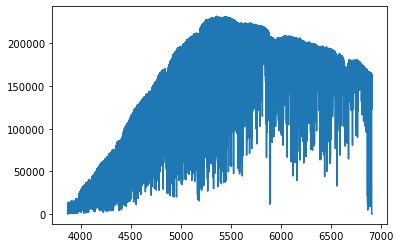

In [9]:
plt.plot(wavelength, sunSpectrum)

In [10]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2020-08-25T21:25:48' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
VERSION =               120203 / Application parameter value                    
DWELL   =               300000 / Application parameter value                    
RD_TIME =                    0 / Application parameter value                    
RS_TIME =                  383 / Application parameter value                    
FRM_TYPE=                    1 / Application parameter value                    
NUM_EXPS=                   

In [35]:
def plotWavelength(wavelength, spectralArr, specLambda, lambdaRange):
    """
    wavelength (list): list of wavelengths presented in the star's data
    spectralArr (list): list of intensity data for each wavelength in wavelength
    specLambda (float): the specific wavelength we want to look at
    lambdaRange (float): the range of wavelength to be shown in the plot
    """
    plt.plot(wavelength, spectralArr)
    plt.grid(True)
    plt.xlim(specLambda-lambdaRange/2, specLambda+lambdaRange/2)
    plt.title(str(specLambda)+" Å")
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.vlines(specLambda, ymin = 0, ymax = 200000)
    plt.show()

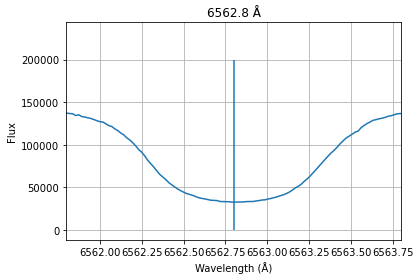

In [47]:
plotWavelength(wavelength, sunSpectrum, 6562.8, 2)
#function test

In [53]:
def isline(wavelength, spectrum, wl, wlrange, doPlot = False):
    """
    wavelength (list): list of wavelength presented in a star's spectrum
    spectrum (list): list of a star's intensity at each wavelength in wavelength
    wl (float): the wavelength we want to find out if there is an absorption line
    wlrange (int): range of specification (default at 1 Angstrom)
    doPlot (bool): indicates if we want to see the plot of the spectrum
    """
    wlList = np.array(wavelength)
    spectrumList = np.array(spectrum)
    indexclosest = np.argmin(np.abs(wlList - wl))
    median = np.median(spectrumList[np.where((wavelength > wl-wlrange/2) & (wavelength < wl+wlrange/2))])
    sd = np.std(spectrumList[np.where((wavelength > wl-wlrange/2) & (wavelength < wl+wlrange/2))])
    mean = np.mean(spectrumList[np.where((wavelength > wl-wlrange/2) & (wavelength < wl+wlrange/2))])
    
    #plot initial spectrum
    if doPlot: 
        plt.plot(wavelength, spectrum)
    
    #initiate variables
    index1 = index2 = indexclosest
    line_exist = False
    plotted_list = {}
    
    #plotting prospective dip
    while spectrum[index1] <= median:
        if doPlot: 
            plt.plot([wavelength[index1]], [spectrum[index1]], 'ko')
        plotted_list[index1] = spectrum[index1]
        index1 += 1
    while spectrum[index2] <= median:
        if doPlot: 
            plt.plot([wavelength[index2]], [spectrum[index2]], 'ko')
        plotted_list[index2] = spectrum[index2]
        index2 -= 1
    
    #determining existence of line
    try: 
        if( 
            plotted_list[indexclosest] != 0 
            and plotted_list[indexclosest] <= np.percentile(list(plotted_list.values()), 3) 
            and abs(median - plotted_list[indexclosest]) >= 2*sd
            and max(plotted_list.values()) - min(plotted_list.values()) >= sd
            and sd/mean >= 0.01
        ):
            line_exist = True
            label_str = "Line detected"
        else:
            label_str = "No line detected"
    except:
        label_str = "No line detected"
    
    #showing plot + return
    if doPlot: 
        plt.grid(True)
        plt.xlim(wl-wlrange/2, wl+wlrange/2)
        plt.title(str(wl)+" Å")
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Intensity') 
        if line_exist:
            plt.vlines(wl, ymin = 0, ymax = 2*median, colors = 'b', label = label_str)
        else:
            plt.vlines(wl, ymin = 0, ymax = 2*median, colors = 'r', label = label_str)
        plt.legend()
        plt.show()

    return line_exist

In [54]:
#a, b, c = isline(wavelength, sunSpectrum, 5000.2109, 1)
#print(a)
#print(b)
#print(c)

In [56]:
isline(wavelength, sunSpectrum, 5000.2109, 1)
#no line but red
#how to turn these red/no red into yes/no
#store the plotted points into the list
#if the point nearest to the center is the lowest in the list then yes; else then no

False

In [16]:
O_data = pd.read_csv("O_lines_vac.csv")
O_data

,element,sp_num,obs_wl_vac(A),ritz_wl_vac(A),intens,Aki(s^-1),Acc,Ei(cm-1),Ek(cm-1),conf_i,term_i,J_i,conf_k,term_k,J_k,Type,tp_ref,line_ref,Unnamed: 18
0,O,8,NaN,1.463430e+01,NaN,8.085000e+10,AA,0.0,-6833270.2344,1s,2S,1/2,6p,2P*,3/2,NaN,T6492extrap,NaN,NaN
1,O,8,NaN,1.463440e+01,NaN,8.085000e+10,AA,0.0,-6833214.5940,1s,2S,1/2,6p,2P*,1/2,NaN,T6492extrap,NaN,NaN
2,O,8,NaN,1.482050e+01,NaN,1.409000e+11,AA,0.0,-6747408.7880,1s,2S,1/2,5p,2P*,3/2,NaN,T6492extrap,NaN,NaN
3,O,8,NaN,1.482070e+01,NaN,1.409000e+11,AA,0.0,-6747312.6360,1s,2S,1/2,5p,2P*,1/2,NaN,T6492extrap,NaN,NaN
4,O,8,NaN,1.517600e+01,NaN,2.794000e+11,AA,0.0,-6589342.716,1s,2S,1/2,4p,2P*,3/2,NaN,T6492extrap,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5908,O,1,NaN,1.670732e+06,NaN,3.920000e+01,C+,102908.489,102968.343,2s2.2p3.(4S*).4d,3D*,1,2s2.2p3.(4S*).4f,3F,2,NaN,T5713LS,NaN,NaN
5909,O,2,NaN,4.995000e+06,NaN,1.300000e-07,B+,26810.55,26830.57,2s2.2p3,2D*,5/2,2s2.2p3,2D*,3/2,M1,T247,L11267,NaN
5910,O,2,NaN,4.995005e+06,NaN,1.490000e-20,E,26810.55,26830.57,2s2.2p3,2D*,5/2,2s2.2p3,2D*,3/2,E2,"T5047,T4644",NaN,NaN
5911,O,2,NaN,5.025000e+07,NaN,4.240000e-24,E,40468.01,40470.00,2s2.2p3,2P*,3/2,2s2.2p3,2P*,1/2,E2,"T5047,T4644",NaN,NaN


In [17]:
o_wl_vac = np.array(O_data["ritz_wl_vac(A)"])
o_wl_vac

array([1.463430e+01, 1.463440e+01, 1.482050e+01, ..., 4.995005e+06,
       5.025000e+07, 5.030000e+07])

In [18]:
n = 1.0002849
def air(lambda_vac, n = 1.0002849):
    lambda_air = lambda_vac/n
    return lambda_air
def doppler(lambda_0, v_r):
    lambda_1 = lambda_0*(1+v_r/(3E5))
    return lambda_1

In [19]:
o_lines_air = []
for wl in o_wl_vac:
    o_lines_air.append(air(wl, n))
o_lines_air

[14.63013187542869,
 14.630231846946804,
 14.816278842157868,
 14.816478785194098,
 15.171677589054879,
 15.17217744664545,
 16.000941331814566,
 16.002140990031936,
 17.800128743321025,
 18.621694679185897,
 18.63239163162415,
 18.725365143470622,
 18.961697812293277,
 18.96709627427146,
 21.595847343091954,
 21.79818969575568,
 21.800788955226654,
 22.09490516151948,
 63.98227145086365,
 63.98437085274405,
 63.985270596407084,
 63.987569941323706,
 64.04305413387726,
 64.04385390602218,
 64.04595330790258,
 67.70261152597625,
 67.70601055759215,
 67.70681032973705,
 67.71040930438917,
 67.77009230070352,
 67.77159187347524,
 67.77579067723606,
 75.81869925258293,
 75.82289805634375,
 75.82889634743061,
 75.83369498030011,
 75.90157564109984,
 75.90517461575197,
 75.91547168211777,
 78.83943864393035,
 78.84313759010058,
 78.84313759010058,
 78.87732784929574,
 78.87732784929574,
 78.87732784929574,
 81.44649589331999,
 81.45049475404457,
 81.45049475404457,
 81.48698435815636,
 81.48

In [20]:
existcount = 0
for o_line in o_lines_air:
    if o_line >= wavelength[0] and o_line <= wavelength[-1]:
        try:
            isline(wavelength, sunSpectrum, o_line, 1)
            if isline(wavelength, sunSpectrum, o_line, 1):
                existcount += 1
        except:
            pass
print(existcount)

9


In [21]:
# print(existcount)

In [22]:
counttt = 0
for wl in o_lines_air:
    if wl >= wavelength[0] and wl <= wavelength[-1]:
        counttt += 1
print(counttt)

867


In [23]:
random_list = np.sort(np.random.uniform(low = wavelength[0], high = wavelength[-1], size = 867))
random_list

array([3869.46038212, 3872.470358  , 3874.96811401, 3885.46431049,
       3885.96601341, 3890.62237535, 3891.52777994, 3893.88552076,
       3894.51105257, 3895.42179441, 3896.60643355, 3900.81268281,
       3902.73189619, 3904.96849038, 3907.59251117, 3915.04819575,
       3924.07790205, 3928.06924123, 3931.12557185, 3935.02750818,
       3935.80711969, 3940.39388605, 3940.80819467, 3946.31013563,
       3947.15747044, 3961.30496138, 3966.48933176, 3972.56434124,
       3974.14413645, 3974.27671087, 3975.03851689, 3977.97041725,
       3979.46239123, 3979.53087271, 3980.67260149, 3981.88460308,
       3986.05497718, 3987.76590238, 3988.00174123, 3992.39200395,
       3995.02767588, 3999.77886073, 4002.33666476, 4002.84122977,
       4005.9618379 , 4011.91994596, 4013.02444579, 4018.72713299,
       4018.7479334 , 4023.37281165, 4024.65080895, 4028.77049445,
       4030.69489945, 4031.29175756, 4045.87949409, 4048.20212869,
       4052.62066747, 4053.79849371, 4053.89723387, 4053.91240

In [24]:
t0 = time.time()
existcount_random = 0
for random_line in random_list:
    if random_line >= wavelength[0] and random_line <= wavelength[-1]:
        try:
            isline(wavelength, sunSpectrum, random_line, 1)
            if isline(wavelength, sunSpectrum, random_line, 1):
                existcount_random += 1
        except:
            pass

In [25]:
print(existcount_random)
t1 = time.time()
print(t1 - t0)

19
2.968640089035034


In [26]:
# t1 = time.time()
# eleven_count = 0
# counts = []
# for i in range(1000):
#     random_list = np.sort(np.random.uniform(low = wavelength[0], high = wavelength[-1], size = 867))
#     existcount_random = 0
#     for random_line in random_list:
#         try:
#             isline(wavelength, sunSpectrum, random_line, 1)
#             if isline(wavelength, sunSpectrum, random_line, 1):
#                 existcount_random += 1
#         except:
#             pass
#     counts.append(existcount_random)
#     if existcount_random == 11:
#         eleven_count += 1

In [27]:
# print(f"{time.time() - t1} seconds")
# print(f"found 11 lines {eleven_count} times out of {len(counts)} iterations which yields {100 - eleven_count/len(counts)*100}% accuracy")
# ite = [i+1 for i in range(len(counts))]
# plt.scatter(ite, counts)
# plt.hlines(y = 11, xmin = 0, xmax = len(counts), colors = 'r')

In [28]:
Fe_data = pd.read_csv("Fe_lines_vac.csv")
Fe_data

/var/folders/jy/sjsyz6954zv918vnjmc0xzfr0000gn/T/ipykernel_68874/3875175086.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  Fe_data = pd.read_csv("Fe_lines_vac.csv")


,element,sp_num,obs_wl_vac(A),unc_obs_wl,ritz_wl_vac(A),unc_ritz_wl,intens,Aki(s^-1),Acc,Ei(cm-1),...,conf_i,term_i,J_i,conf_k,term_k,J_k,Type,tp_ref,line_ref,Unnamed: 20
0,Fe,26,NaN,NaN,1.391696e+00,0.00001,NaN,1.610000e+13,A,0,...,1s,2S,1/2,5p,2P*,3/2,NaN,T7228extrap,L11926,NaN
1,Fe,26,NaN,NaN,1.424905e+00,0.00001,NaN,3.200000e+13,A,0,...,1s,2S,1/2,4p,2P*,3/2,NaN,T7228extrap,L11926,NaN
2,Fe,25,NaN,NaN,1.460800e+00,0.00100,NaN,2.540000e+13,B,0,...,1s2,1S,0,1s.5p,1P*,1,NaN,T3221,NaN,NaN
3,Fe,25,NaN,NaN,1.461200e+00,0.00100,NaN,3.100000e+12,E,0,...,1s2,1S,0,1s.5p,3P*,1,NaN,T5298interp,NaN,NaN
4,Fe,25,NaN,NaN,1.494600e+00,0.00100,NaN,5.050000e+13,B,0,...,1s2,1S,0,1s.4p,1P*,1,NaN,T3221,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33987,Fe,1,NaN,NaN,5.431090e+05,4.00000,NaN,5.920000e-04,B,704.007,...,3d6.4s2,a 5D,2,3d6.4s2,a 5D,1,M1,T6409,NaN,NaN
33988,Fe,13,NaN,NaN,6.450000e+05,59000.00000,NaN,1.000000e-04,E,287205.0,...,3s.3p3,3D*,1,3s.3p3,3D*,2,M1,T4830,NaN,NaN
33989,Fe,5,NaN,NaN,7.020000e+05,5000.00000,NaN,1.561000e-04,A+,0.0,...,3d4,5D,0,3d4,5D,1,M1,T9277,NaN,NaN
33990,Fe,2,873832.7,0.5,8.738360e+05,4.00000,NaN,1.890000e-04,B,862.6118,...,3d6.(5D).4s,a 6D,3/2,3d6.(5D).4s,a 6D,1/2,M1,"T7958,T247c82",L9404,NaN


In [29]:
Fe_wl_vac = np.array(Fe_data["ritz_wl_vac(A)"])
Fe_wl_vac

array([1.391696e+00, 1.424905e+00, 1.460800e+00, ..., 7.020000e+05,
       8.738360e+05, 1.111828e+06])

In [30]:
Fe_lines_air = []
for wl in Fe_wl_vac:
    Fe_lines_air.append(air(wl, n))
Fe_lines_air

[1.3912996187386213,
 1.424499160189262,
 1.460383936616458,
 1.460783822688916,
 1.494174309739155,
 1.4948741103659569,
 1.5019221023930283,
 1.5030677759906201,
 1.5727519229771436,
 1.5745514103032046,
 1.7741945319778394,
 1.777509587518516,
 1.7785932787748768,
 1.7825921394994564,
 1.7829340420914082,
 1.7829920255719145,
 1.786591000224036,
 1.786790943260265,
 1.787590715405181,
 1.788190544513868,
 1.7893902027312418,
 1.7898900603218142,
 1.7914896046116462,
 1.7915895761297607,
 1.792089433720333,
 1.792489319792791,
 1.7927892343471343,
 1.7936889780101648,
 1.7967880950717139,
 1.7983876393615459,
 1.7997872406151487,
 1.8009868988325226,
 1.8018866424955529,
 1.8105841645715135,
 1.8446744522485543,
 1.8460740535021571,
 1.8498729711905078,
 1.8514725154803398,
 1.852222301866198,
 1.853002079707491,
 1.8534719458426294,
 1.8557712907592627,
 1.8548715470962323,
 1.8555213619639763,
 1.8572708635309798,
 1.856381117019761,
 1.8565110799933098,
 1.857470806567209,
 1.8580

In [31]:
Fe_count = 0
for Fe_line in Fe_lines_air:
    if Fe_line >= wavelength[0] and Fe_line <= wavelength[-1]:
        Fe_count += 1
print(Fe_count)

4516


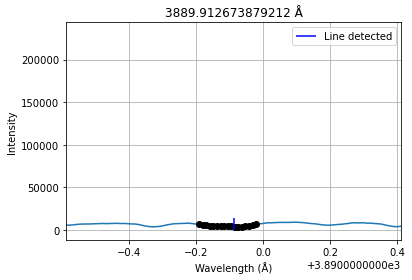

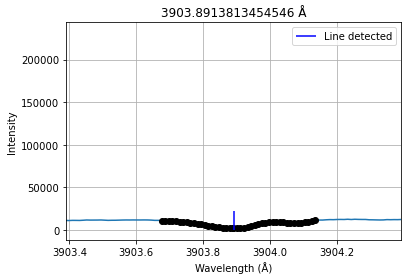

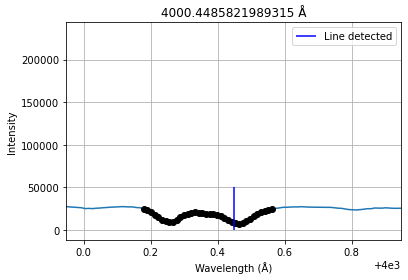

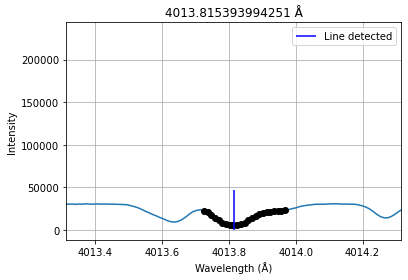

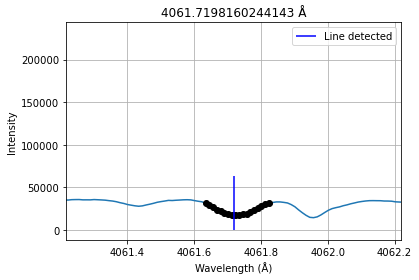

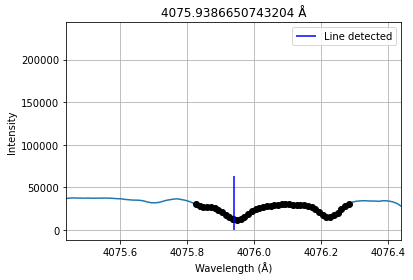

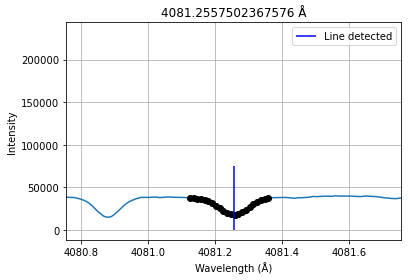

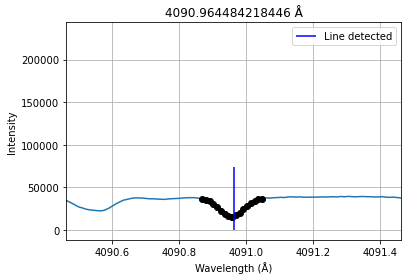

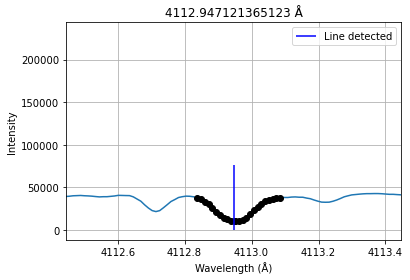

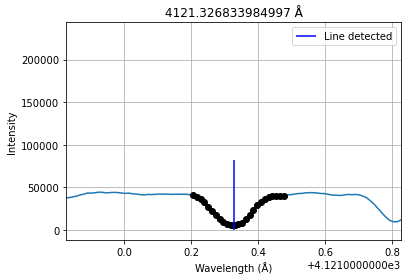

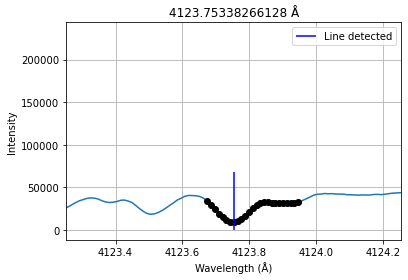

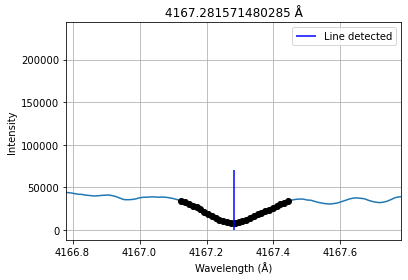

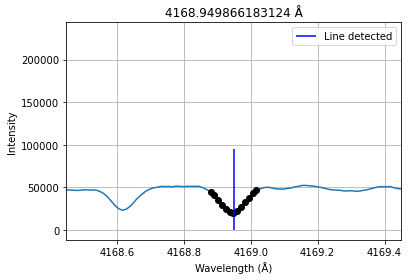

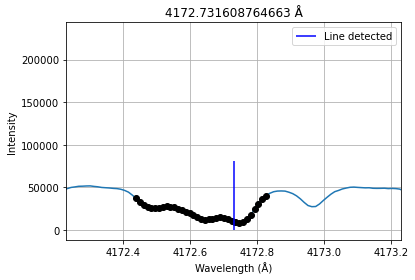

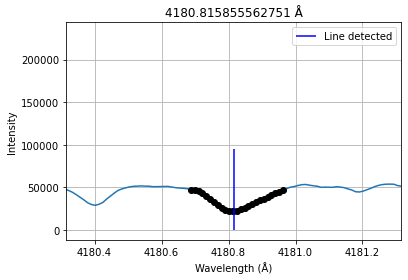

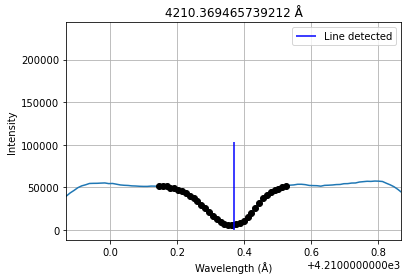

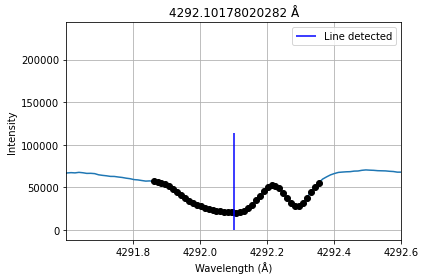

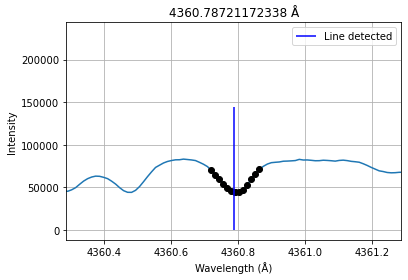

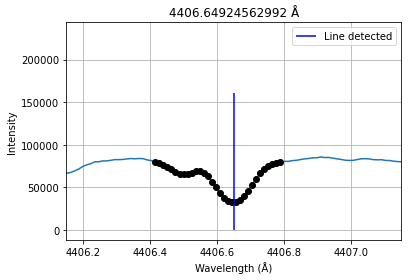

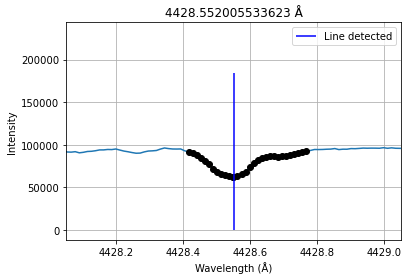

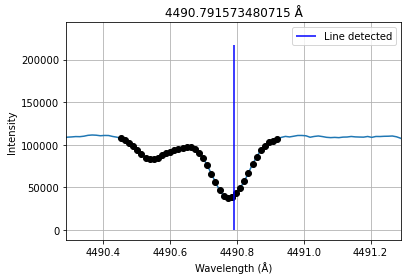

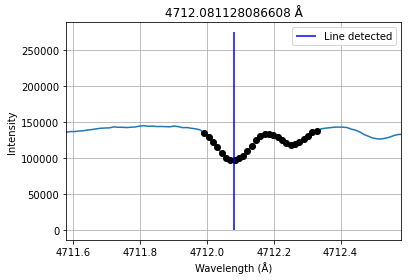

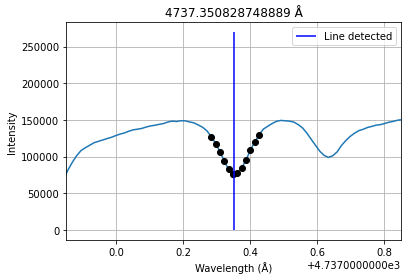

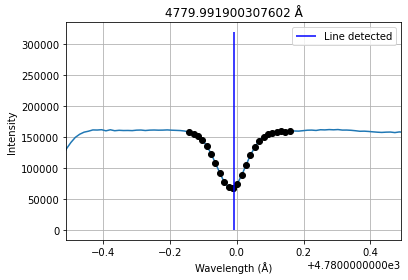

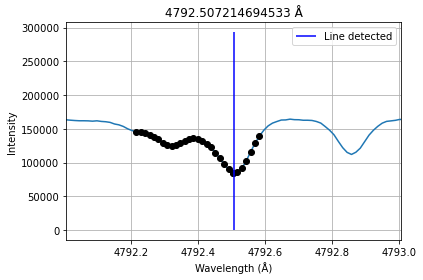

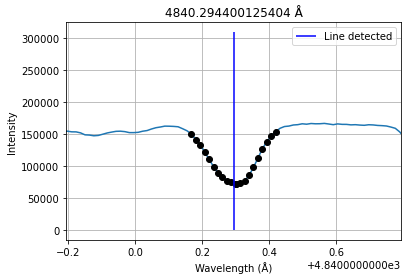

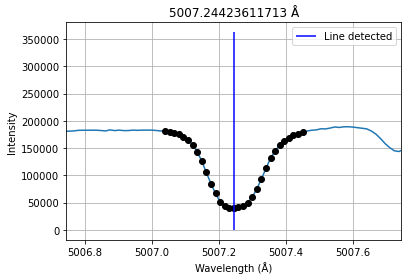

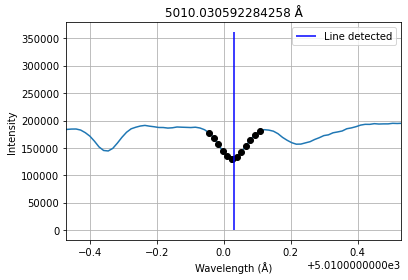

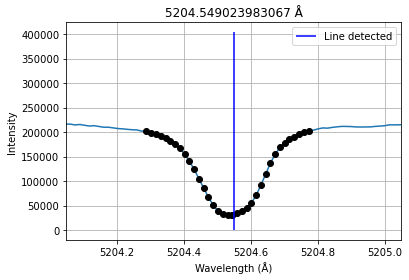

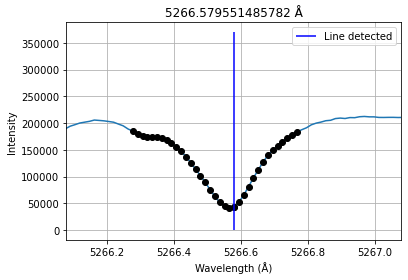

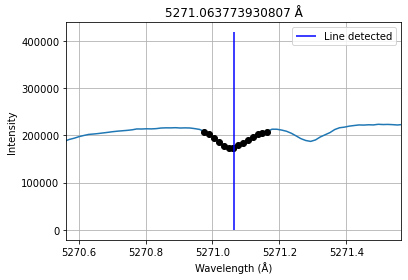

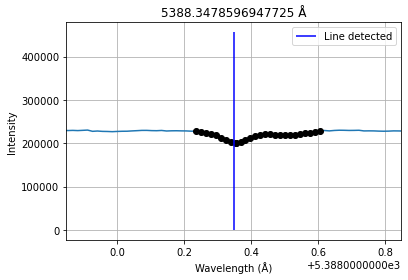

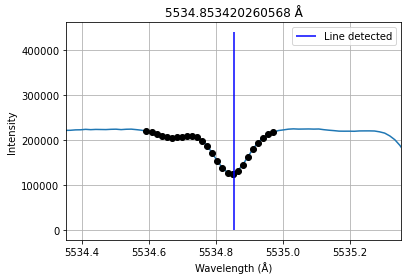

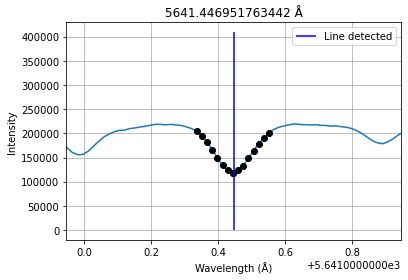

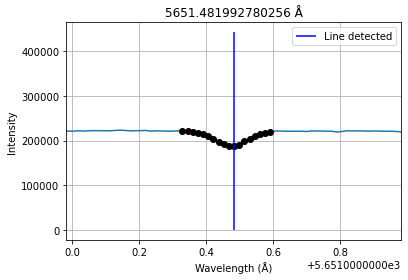

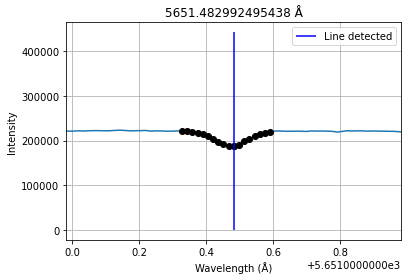

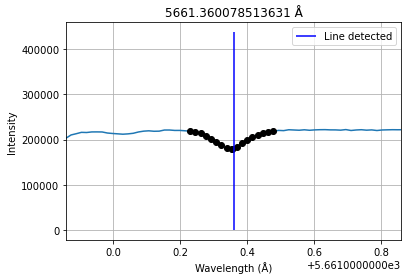

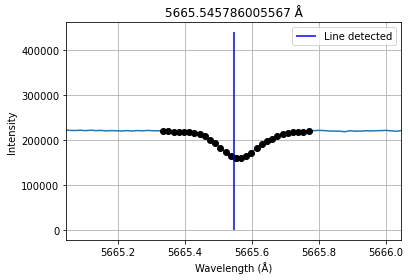

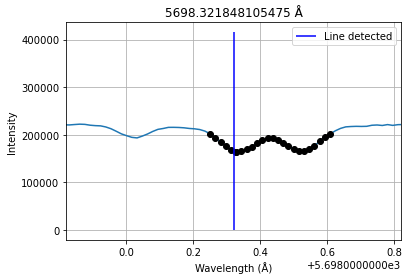

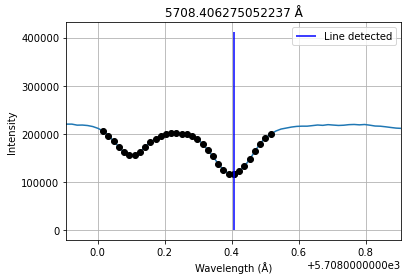

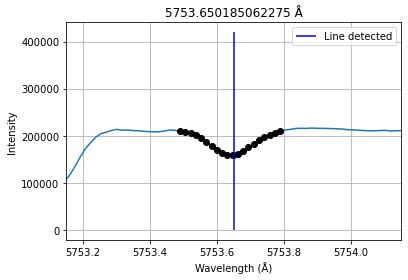

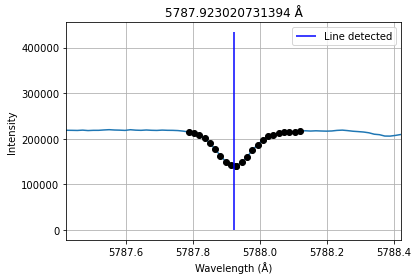

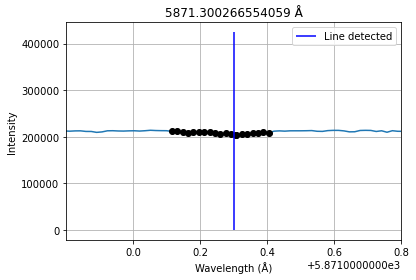

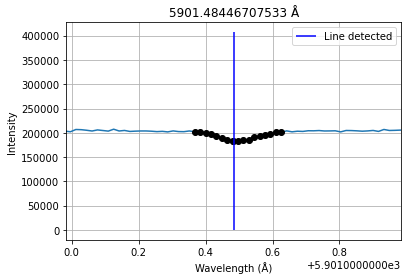

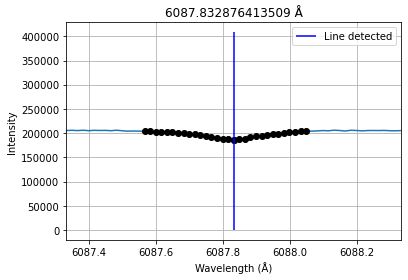

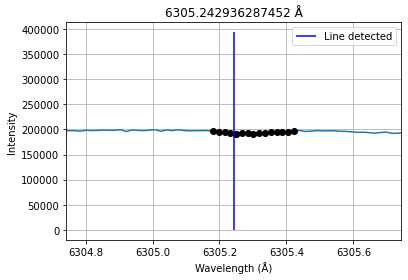

46
127.6797468662262


In [32]:
t2 = time.time()
existcount_Fe = 0
for Fe_line in Fe_lines_air:
    if Fe_line >= wavelength[0] and Fe_line <= wavelength[-1]:
        try:
            isline(wavelength, sunSpectrum, Fe_line, 1, True)
            if isline(wavelength, sunSpectrum, Fe_line, 1):
                existcount_Fe += 1
        except:
            pass
print(existcount_Fe)
t3 = time.time()
print(t3 - t2)

In [33]:
# t1 = time.time()
# num_count = 0
# counts = []
# for i in range(100):
#     random_list = np.sort(np.random.uniform(low = wavelength[0], high = wavelength[-1], size = 4516))
#     existcount_random = 0
#     for random_line in random_list:
#         try:
#             isline(wavelength, sunSpectrum, random_line, 1)
#             if isline(wavelength, sunSpectrum, random_line, 1):
#                 existcount_random += 1
#         except:
#             pass
#     counts.append(existcount_random)
#     if existcount_random == 78:
#         num_count += 1

In [34]:
# t2 = time.time()
# print(f"found 78 lines {num_count} times out of {len(counts)} iterations which yields {100 - num_count/len(counts)*100}% accuracy")
# print(f"The code runs for {t2 - t1} seconds")
# ite = [i+1 for i in range(len(counts))]
# plt.scatter(ite, counts)
# plt.hlines(y = 78, xmin = 0, xmax = len(counts), colors = 'r')